In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import string, re
import pandas_profiling
import itertools 
import pickle
import sklearn
import xgboost as xgb

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
data_iteration = 1
model_iteration = 1

In [5]:
data_file_path = 'data/20191111-' + str(data_iteration) + '_'
model_file_path = 'models/20191111-' + str(model_iteration) + '_'

In [6]:
test_features = pickle.load(open(data_file_path + 'test_features.pkl', 'rb'))
test_labels = pickle.load(open(data_file_path + 'test_labels.pkl', 'rb'))
train_features = pickle.load(open(data_file_path + 'train_features.pkl', 'rb'))
train_labels = pickle.load(open(data_file_path + 'train_labels.pkl', 'rb'))

In [78]:
# model = requests.get("https://fakenewsstorage.blob.core.windows.net/fakenewsmodels/voting_classifier.pkl")

In [79]:
# model = requests.get("https://fakenewsstorage.blob.core.windows.net/fakenewsmodels/random_forest_classifier.pkl")

In [7]:
RFC = pickle.load(open(model_file_path + 'RandomForestClassifier.pkl', 'rb'))
VC = pickle.load(open(model_file_path + 'VotingClassifier.pkl', 'rb'))
# XGB = pickle.load(open(model_file_path + 'XGBClassifier.pkl', 'rb'))

In [8]:
model_list = [RFC, VC]

## Make confusion matrix (cm)
matrix as follows:

    Expected down the side: Each row of the matrix corresponds to a predicted class.
    Predicted across the top: Each column of the matrix corresponds to an actual class.

The counts of correct and incorrect classification are then filled into the table.


    “true positive” for correctly predicted event values.
    “false positive” for incorrectly predicted event values.
    “true negative” for correctly predicted no-event values.
    “false negative” for incorrectly predicted no-event values.

We can summarize this in the confusion matrix as follows:
-  			event			no-event
- event		true positive		false positive
- no-event	false negative		true negative

This can help in calculating more advanced classification metrics such as precision, recall, specificity and sensitivity of our classifier.|

In [9]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import f1_score
for model in model_list:
    predictions = model.predict(test_features)
    cm = confusion_matrix(test_labels, predictions)
    print(cm)
#     mlcm = multilabel_confusion_matrix(test_labels, predictions)
    print(f1_score(test_labels, predictions, average='macro'))

[[1248  585   40]
 [ 516 1056   26]
 [ 165  232   21]]
0.4493783596941827
[[1461  363   49]
 [ 674  860   64]
 [ 212  174   32]]
0.46012809251518966


In [16]:
mlcm

array([[[1362,  654],
        [ 631, 1242]],

       [[1427,  864],
        [ 472, 1126]],

       [[3470,    1],
        [ 416,    2]]], dtype=int64)

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.tight_layout()

Confusion matrix, without normalization
[[1307  561    5]
 [ 582 1003   13]
 [ 196  212   10]]


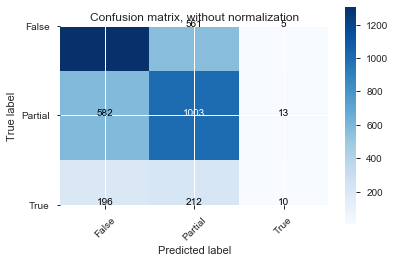

In [63]:
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['False', 'Partial', 'True'],
                      title='Confusion matrix, without normalization')

In [11]:
from sklearn.metrics import accuracy_score
predictions = RFC.predict(test_features)
print("Training accuracy is: ", accuracy_score(train_labels, RFC.predict(train_features)))
print("Test accuracy is: ", accuracy_score(test_labels, predictions))

Training accuracy is:  0.9915995199725699
Test accuracy is:  0.5978400617125225


In [12]:
importances = RFC.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFC.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

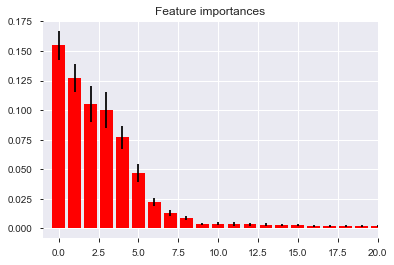

In [13]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, 20]) 
# X.shape[1]]
plt.show()

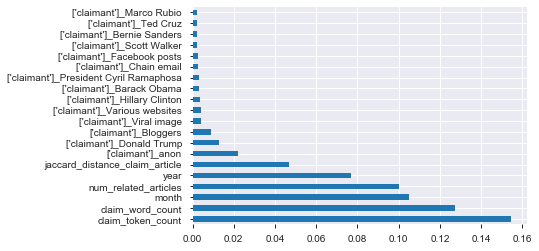

In [14]:
feat_importances = pd.Series(importances, index=train_features.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [15]:
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:


NameError: name 'X' is not defined

## Feature selection

In [5]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [ ]:
rfecv = RFECV(estimator=model, step=1, cv=10,
              scoring='accuracy')
rfecv.fit(train_features, train_labels)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = train_features  #independent columns
y = train_labels    #target column-apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

ValueError: Input X must be non-negative.

In [30]:
from local_modules.scoring.score import calculate_score 

In [31]:
calculate_score(7, 74, 971, 771, 1286, 817, 411, 627, 587)

Precision is: 0.009818938537999753
Recall is: 0.002328874843510748


2.0

In [32]:
calculate_score(7, 74, 971, 771, 1286, 817, 411, 627, 587)

Precision is: 0.009818938537999753
Recall is: 0.002328874843510748
Updated


2.0